<a href="https://colab.research.google.com/github/mattkingros/Classwork/blob/main/ViT_B16_augreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax_augreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## How to train your ViT? Data, Augmentation, and Regularization in Vision Transformers

Model repository published with the paper

[**How to train your ViT? Data, Augmentation, and Regularization in Vision
Transformers**](https://arxiv.org/abs/TODO)

This Colab shows how to
[find checkpoints](#scrollTo=F4SLGDtFxlsC)
in the repository, how to
[select and load a model](#scrollTo=wh_SLkQtQ6K4)
form the repository and use it for inference
([also with PyTorch](#scrollTo=1nMyWmDycpAo)),
and how to
[fine-tune on a dataset](#scrollTo=iAruT3YOxqB6).

For more details, please refer to the repository:

https://github.com/google-research/vision_transformer/

Note that this Colab directly uses the unmodified code from the repository. If
you want to modify the modules and persist your changes, you can do all that
using free GPUs and TPUs without leaving the Colab environment - see

https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax.ipynb

### Imports

In [ ]:
# Fetch vision_transformer repository.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer


Cloning into 'vision_transformer'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 37 (delta 4), reused 29 (delta 4), pack-reused 0
Unpacking objects: 100% (37/37), done.


In [ ]:
# Install dependencies.
!pip install -qr vision_transformer/vit_jax/requirements.txt

     |████████████████████████████████| 65 kB 1.4 MB/s 
     |████████████████████████████████| 77 kB 4.2 MB/s 
     |████████████████████████████████| 207 kB 23.6 MB/s 
     |████████████████████████████████| 88 kB 5.0 MB/s 
     |████████████████████████████████| 179.8 MB 67 kB/s 
     |████████████████████████████████| 126 kB 40.8 MB/s 


In [ ]:
# Import files from repository.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import models
from vit_jax import train
from vit_jax.configs import augreg as augreg_config
from vit_jax.configs import models as models_config

In [ ]:
# Connect to TPUs if runtime type is of type TPU.

import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  # Otherwise print information about GPU.
  !nvidia-smi

Mon Dec 13 15:43:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Some more imports used in this Colab.

import glob
import os
import random
import shutil
import time

from absl import logging
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

pd.options.display.max_colwidth = None
logging.set_verbosity(logging.INFO)  # Shows logs during training.

### Explore checkpoints

This section contains shows how to use the `index.csv` table for model
selection.

See
[`vit_jax.checkpoint.get_augreg_df()`](https://github.com/google-research/vision_transformer/blob/ed1491238f5ff6099cca81087c575a215281ed14/vit_jax/checkpoint.py#L181-L228)
for a detailed description of the individual columns

In [ ]:
# Load master table from Cloud.
with tf.io.gfile.GFile('gs://vit_models/augreg/index.csv') as f:
  df = pd.read_csv(f)

In [ ]:
# This is a pretty large table with lots of columns:
print(f'loaded {len(df):,} rows')
df.columns

loaded 51,509 rows


Index(['name', 'ds', 'epochs', 'lr', 'aug', 'wd', 'do', 'sd', 'best_val',
       'final_val', 'final_test', 'adapt_ds', 'adapt_lr', 'adapt_steps',
       'adapt_resolution', 'adapt_final_val', 'adapt_final_test', 'params',
       'infer_samples_per_sec', 'filename', 'adapt_filename'],
      dtype='object')

In [ ]:
# Number of distinct checkpoints
len(tf.io.gfile.glob('gs://vit_models/augreg/*.npz'))

52268

In [ ]:
# Any column prefixed with "adapt_" pertains to the fine-tuned checkpoints.
# Any column without that prefix pertains to the pre-trained checkpoints.
len(set(df.filename)), len(set(df.adapt_filename))

(759, 51509)

In [ ]:
df.name.unique()

array(['Ti/16', 'S/32', 'B/16', 'L/16', 'R50+L/32', 'R26+S/32', 'S/16',
       'B/32', 'R+Ti/16', 'B/8'], dtype=object)

In [ ]:
# Upstream AugReg parameters (section 3.3):
(
df.groupby(['ds', 'name', 'wd', 'do', 'sd', 'aug']).filename
  .count().unstack().unstack().unstack()
  .dropna(1, 'all').fillna(0).astype(int)
  .iloc[:7]  # Just show beginning of a long table.
)

aug              light0     light1     medium1  ... none strong1     strong2    
sd                  0.0 0.1    0.0 0.1     0.0  ...  0.1     0.0 0.1     0.0 0.1
do                  0.0 0.1    0.0 0.1     0.0  ...  0.1     0.0 0.1     0.0 0.1
ds  name    wd                                  ...                             
i1k B/16    0.03     68  68     68  68      68  ...   68      68  68      68  68
            0.10     68  68     68  68      68  ...   68      68  68      68  68
    B/32    0.03     68  68     68  68      68  ...   68      68  68      68  68
            0.10     68  68     68  68      68  ...   68      68  68      68  68
    L/16    0.03     68  68     68  68      68  ...   68      68  68      68  68
            0.10     68  68     68  68      68  ...   68      68  68      68  68
    R+Ti/16 0.03     68  68     68  68      68  ...   68      68  68      68  68

[7 rows x 14 columns]

In [ ]:
# Downstream parameters (table 4)
# (Imbalance in 224 vs. 384 is due to recently added B/8 checkpoints)
(
df.groupby(['adapt_resolution', 'adapt_ds', 'adapt_lr', 'adapt_steps']).filename
  .count().astype(str).unstack().unstack()
  .dropna(1, 'all').fillna('')
)

adapt_steps                      500                ... 10000 20000      
adapt_lr                         0.001 0.003 0.010  ... 0.030 0.010 0.030
adapt_resolution adapt_ds                           ...                  
224              cifar100                           ...   759            
                 imagenet2012                       ...         759   759
                 kitti             759   759   759  ...                  
                 oxford_iiit_pet   759   759   759  ...                  
                 resisc45                           ...   759            
384              cifar100                           ...   756            
                 imagenet2012                       ...         756   755
                 kitti             756   756   756  ...                  
                 oxford_iiit_pet   756   756   756  ...                  
                 resisc45                           ...   756            

[10 rows x 14 columns]

In [ ]:
# Let's first select the "best checkpoint" for every model. We show in the
# paper (section 4.5) that one can get a good performance by simply choosing the
# best model by final pre-train validation accuracy ("final-val" column).
# Pre-training with imagenet21k 300 epochs (ds=="i21k") gives the best
# performance in almost all cases (figure 6, table 5).
best_filenames = set(
    df.query('ds=="i21k"')
    .groupby('name')
    .apply(lambda df: df.sort_values('final_val').iloc[-1])
    .filename
)

# Select all finetunes from these models.
best_df = df.loc[df.filename.apply(lambda filename: filename in best_filenames)]

# Note: 9 * 68 == 612
len(best_filenames), len(best_df)

(10, 646)

In [ ]:
best_df.columns

Index(['name', 'ds', 'epochs', 'lr', 'aug', 'wd', 'do', 'sd', 'best_val',
       'final_val', 'final_test', 'adapt_ds', 'adapt_lr', 'adapt_steps',
       'adapt_resolution', 'adapt_final_val', 'adapt_final_test', 'params',
       'infer_samples_per_sec', 'filename', 'adapt_filename'],
      dtype='object')

In [ ]:
# Note that this dataframe contains the models from the "i21k_300" column of
# table 3:
best_df.query('adapt_ds=="imagenet2012"').groupby('name').apply(
    lambda df: df.sort_values('adapt_final_val').iloc[-1]
)[[
   # Columns from upstream
   'name', 'ds', 'filename',
   # Columns from downstream
   'adapt_resolution', 'infer_samples_per_sec','adapt_ds', 'adapt_final_test', 'adapt_filename',
]].sort_values('infer_samples_per_sec')

,name,ds,filename,adapt_resolution,infer_samples_per_sec,adapt_ds,adapt_final_test,adapt_filename
name,,,,,,,,
L/16,L/16,i21k,L_16-i21k-300ep-lr_0.001-aug_strong1-wd_0.1-do_0.0-sd_0.0,384,49.87,imagenet2012,0.85588,L_16-i21k-300ep-lr_0.001-aug_strong1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_384
B/16,B/16,i21k,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0,384,137.92,imagenet2012,0.85486,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384
S/16,S/16,i21k,S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0,384,300.12,imagenet2012,0.83728,S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384
R50+L/32,R50+L/32,i21k,R50_L_32-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.1-sd_0.1,384,326.73,imagenet2012,0.85992,R50_L_32-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.1-sd_0.1--imagenet2012-steps_20k-lr_0.01-res_384
R26+S/32,R26+S/32,i21k,R26_S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0,384,560.40,imagenet2012,0.83846,R26_S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_384
Ti/16,Ti/16,i21k,Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0,384,609.58,imagenet2012,0.78220,Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384
B/32,B/32,i21k,B_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0,384,954.94,imagenet2012,0.83586,B_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_384
S/32,S/32,i21k,S_32-i21k-300ep-lr_0.001-aug_none-wd_0.1-do_0.0-sd_0.0,384,2153.94,imagenet2012,0.79584,S_32-i21k-300ep-lr_0.001-aug_none-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_384
R+Ti/16,R+Ti/16,i21k,R_Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0,384,2425.77,imagenet2012,0.75402,R_Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384


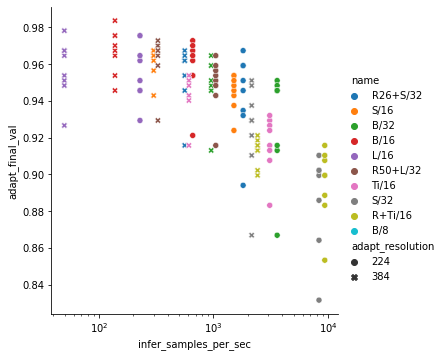

In [ ]:
# Visualize the 2 (resolution) * 9 (models) * 8 (lr, steps) finetunings for a
# single dataset (Pets37).
# Note how larger models get better scores up to B/16 @384 even on this tiny
# dataset, if pre-trained sufficiently.
sns.relplot(
    data=best_df.query('adapt_ds=="oxford_iiit_pet"'),
    x='infer_samples_per_sec',
    y='adapt_final_val',
    hue='name',
    style='adapt_resolution'
)
plt.gca().set_xscale('log');

In [ ]:
# More details for a single pre-trained checkpoint.
best_df.query('name=="B/16" and adapt_ds=="cifar100"')[[
  col for col in best_df.columns if col.startswith('adapt_')
]].sort_values('adapt_final_val')

,adapt_ds,adapt_lr,adapt_steps,adapt_resolution,adapt_final_val,adapt_final_test,adapt_filename
24013,cifar100,0.001,2500,384,0.904,0.9196,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_2k-lr_0.001-res_384
24047,cifar100,0.001,2500,224,0.918,0.9268,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_2k-lr_0.001-res_224
24006,cifar100,0.030,10000,384,0.919,0.9147,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.03-res_384
24040,cifar100,0.030,10000,224,0.921,0.9139,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.03-res_224
24012,cifar100,0.003,2500,384,0.922,0.9345,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_2k-lr_0.003-res_384
24007,cifar100,0.010,10000,384,0.925,0.9323,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.01-res_384
24009,cifar100,0.001,10000,384,0.926,0.9349,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.001-res_384
24010,cifar100,0.030,2500,384,0.927,0.9335,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_2k-lr_0.03-res_384
24046,cifar100,0.003,2500,224,0.927,0.9371,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_2k-lr_0.003-res_224
24043,cifar100,0.001,10000,224,0.929,0.9393,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.001-res_224


### Load a checkpoint

In [ ]:
# Select a value from "adapt_filename" above that is a fine-tuned checkpoint.
filename = 'B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.003-res_224'

tfds_name = filename.split('--')[1].split('-')[0]
model_config = models_config.AUGREG_CONFIGS[filename.split('-')[0]]
resolution = int(filename.split('_')[-1])
path = f'gs://vit_models/augreg/{filename}.npz'

print(f'{tf.io.gfile.stat(path).length / 1024 / 1024:.1f} MiB - {path}')

327.7 MiB - gs://vit_models/augreg/B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--cifar100-steps_10k-lr_0.003-res_224.npz


In [ ]:
# Fetch dataset that the checkpoint was finetuned on.
# (Note that automatic download does not work with imagenet2012)
ds, ds_info = tfds.load(tfds_name, with_info=True)
ds_info

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar100/3.0.2
INFO:absl:Load dataset info from /tmp/tmpe4hqbhy1tfds
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Generating dataset cifar100 (/root/tensorflow_datasets/cifar100/3.0.2)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:Downloading https://www.cs.toronto.edu/~kriz/cifar-100-binary.tar.gz into /root/tensorflow_datasets/downloads/cs.toronto.edu_kriz_cifar-100-binaryzK0jb7CkNxmV4pH2clu5WdAlIotsPlZhrMxx9-DELEk.tar.gz.tmp.e57d709c68df48178b0665fecb2047e2...
INFO:absl:Generating split train


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incompleteH0DW3Y/cifar100-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/cifar100/3.0.2.incompleteH0DW3Y/cifar100-train.tfrecord. Shard lengths: [50000]
INFO:absl:Generating split test


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar100/3.0.2.incompleteH0DW3Y/cifar100-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/cifar100/3.0.2.incompleteH0DW3Y/cifar100-test.tfrecord. Shard lengths: [10000]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.SKIP.
INFO:absl:Constructing tf.data.Dataset for split None, from /root/tensorflow_datasets/cifar100/3.0.2


Dataset cifar100 downloaded and prepared to /root/tensorflow_datasets/cifar100/3.0.2. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='cifar100',
    version=3.0.2,
    description='This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).',
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {

In [ ]:
# Get model instance - no weights are initialized yet.
model = models.VisionTransformer(
    num_classes=ds_info.features['label'].num_classes, **model_config)

In [ ]:
# Load a checkpoint from cloud - for large checkpoints this can take a while...
params = checkpoint.load(path)

In [ ]:
# Get a single example from dataset for inference.
d = next(iter(ds['test']))
d['label']
len(ds['test'])


10000

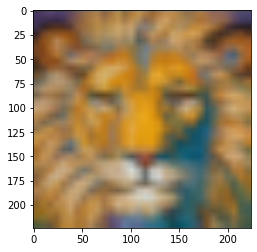

In [ ]:
def pp(img, sz):
  """Simple image preprocessing."""
  img = tf.cast(img, float) / 255.0
  img = tf.image.resize(img, [sz, sz])
  return img

plt.imshow(pp(d['image'], resolution));

#### Using `timm`

If you know PyTorch, you're probably already familiar with `timm`.

If not yet - it's your lucky day! Please check out their docs here:

https://rwightman.github.io/pytorch-image-models/

In [ ]:
# Checkpoints can also be loaded directly into timm...
!pip install timm
import timm
import torch
import torch.nn.functional as nnf
import numpy as np

     |████████████████████████████████| 376 kB 5.0 MB/s 


In [ ]:
# For available model names, see here:
# https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
# https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer_hybrid.py
timm_model = timm.create_model(
    'vit_base_patch16_224', num_classes=ds_info.features['label'].num_classes)

# Non-default checkpoints need to be loaded from local files.
if not tf.io.gfile.exists(f'{filename}.npz'):
  tf.io.gfile.copy(f'gs://vit_models/augreg/{filename}.npz', f'{filename}.npz')
timm.models.load_checkpoint(timm_model, f'{filename}.npz')

In [ ]:
def pp_torch(img, sz):
  """Simple image preprocessing for PyTorch."""
  img = pp(img, sz)
  img = img.numpy().transpose([2, 0, 1])  # PyTorch expects NCHW format.
  return torch.tensor(img[None])

with torch.no_grad():
  logits, = timm_model(pp_torch(d['image'], resolution)).detach().numpy()
  label = np.argmax(logits)
  print(label)
  print(np.array(d['label']))

print(len(ds['test']))

88
43
10000


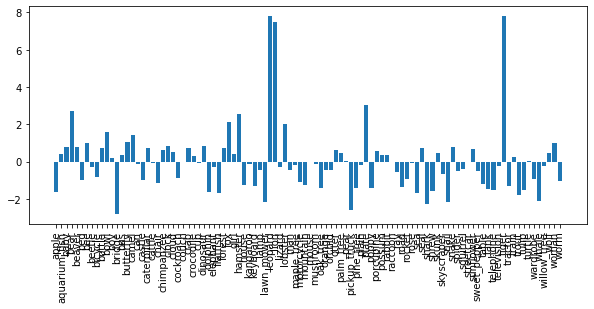

In [ ]:
# Same results as above (since we loaded the same checkpoint).
plt.figure(figsize=(10, 4))
plt.bar(list(map(ds_info.features['label'].int2str, range(len(logits)))), logits)
plt.xticks(rotation=90);

In [ ]:
running_acc = 0;
test = 0;
for d in ds['test']:
  logits, = timm_model(pp_torch(d['image'], resolution)).detach().numpy()
  label = np.argmax(logits)
  running_acc = running_acc + (np.array(d['label']) == label)
  test = test+1
  if(test%100==0):
    print(['Test #', test])
    print(running_acc/test)
  if(test%2500 ==0):
    break

print(running_acc/test)


KeyboardInterrupt: ignored